In [1]:
import matplotlib.pyplot as plt
import mplhep
# plt.style.use(mplhep.style.ATLAS)  # ATLAS/CMS/ALICE plot style
import numpy as np
import pandas as pd
import scipy.optimize as sc

In [2]:
# energy calibration
# get filepath of all calibration data
energy_path = 'Rotatable_Scintillator/'

Na_file1 = energy_path + 'Na_22_rot_1.TKA'
df_Na1 = pd.read_csv(Na_file1, header=None)
N_Na1 = np.array(df_Na1[0][2:])
t_Na1 = df_Na1[0][0]  # live time [s]

Na_file2 = energy_path + 'Na_22_rot_2.TKA'
df_Na2 = pd.read_csv(Na_file2, header=None)
N_Na2 = np.array(df_Na2[0][2:])
t_Na2 = df_Na2[0][0]  # live time [s]

Na_file3 = energy_path + 'Na_22_rot_3.TKA'
df_Na3 = pd.read_csv(Na_file3, header=None)
N_Na3 = np.array(df_Na3[0][2:])
t_Na3 = df_Na3[0][0]  # live time [s]

Co_file1 = energy_path + 'Co_60_rot_1.TKA'
df_Co1 = pd.read_csv(Co_file1, header=None)
N_Co1 = np.array(df_Co1[0][2:])
t_Co1 = df_Co1[0][0]  # live time [s]

Co_file2 = energy_path + 'Co_60_rot_2.TKA'
df_Co2 = pd.read_csv(Co_file2, header=None)
N_Co2 = np.array(df_Co2[0][2:])
t_Co2 = df_Co2[0][0]  # live time [s]

Co_file3 = energy_path + 'Co_60_rot_3.TKA'
df_Co3 = pd.read_csv(Co_file3, header=None)
N_Co3 = np.array(df_Co3[0][2:])
t_Co3 = df_Co3[0][0]  # live time [s]

Pd_file = energy_path + 'Pd_106_rot_1.TKA'
df_Pd = pd.read_csv(Pd_file, header=None)
N_Pd = np.array(df_Pd[0][2:])
t_Pd = df_Pd[0][0]  # live time [s]

under_file = energy_path + 'background_rot_1.TKA'
df_under = pd.read_csv(under_file, header=None)
N_under = np.array(df_under[0][2:])
t_under = df_under[0][0]  # live time [s]

In [3]:
def counting_rate(N, t):
    '''Calculate counting rate and uncertainty'''
    n = N / t
    u_n = np.sqrt(N) / t
    return n, u_n


def corrected_rate(N, t):
    '''Calculate counting rate corrected for underground with uncertainty'''
    n_raw, u_raw = counting_rate(N, t)
    n_under, u_under = counting_rate(N_under, t_under)

    n_corr = n_raw - n_under
    n_corr = np.where(n_corr>0, n_corr, 0)
    u_corr = np.sqrt(u_raw**2 + u_under**2)

    return n_corr, u_corr

In [4]:
n_Na1, u_Na1 = corrected_rate(N_Na1, t_Na1)
n_Na2, u_Na2 = corrected_rate(N_Na2, t_Na2)
n_Na3, u_Na3 = corrected_rate(N_Na3, t_Na3)

n_Na = [n_Na1, n_Na2, n_Na3]
u_Na = [u_Na1, u_Na2, u_Na3]

n_Co1, u_Co1 = corrected_rate(N_Co1, t_Co1)
n_Co2, u_Co2 = corrected_rate(N_Co2, t_Co2)
n_Co3, u_Co3 = corrected_rate(N_Co3, t_Co3)

n_Co = [n_Co1, n_Co2, n_Co3]
u_Co = [u_Co1, u_Co2, u_Co3]

n_Pd, u_Pd = corrected_rate(N_Pd, t_Pd)

n_under, u_under = counting_rate(N_under, t_under)

In [5]:
def gauss(x, A, mu, sigma, B):
    return A * np.exp(-(x-mu)**2 / (2*sigma**2)) + B

def linear_fct(x, m, c):
    return m * x + c

[2.50974506e+00 3.09652708e+03 1.08431268e+02 1.20302826e-01] [0.00565751 0.21064375 0.21666196 0.00126871]
[2.95168658e-01 7.49431431e+03 1.81545626e+02 2.14809576e-02] [1.69641778e-03 8.59455373e-01 1.42080266e+00 1.24338000e-03]
[2.46940591e+00 3.08605592e+03 1.08750063e+02 1.15167536e-01] [0.00660478 0.24990777 0.25622721 0.00146288]
[2.95776537e-01 7.47237137e+03 1.80611125e+02 2.15356556e-02] [1.95574493e-03 1.02230046e+00 1.51782627e+00 1.24597933e-03]
[2.55495895e+00 3.08655668e+03 1.08434256e+02 1.16563897e-01] [0.00735636 0.26838008 0.27403119 0.00161173]
[2.95338957e-01 7.47027535e+03 1.81124298e+02 2.29483976e-02] [2.14981397e-03 1.13059124e+00 1.67833351e+00 1.36374320e-03]


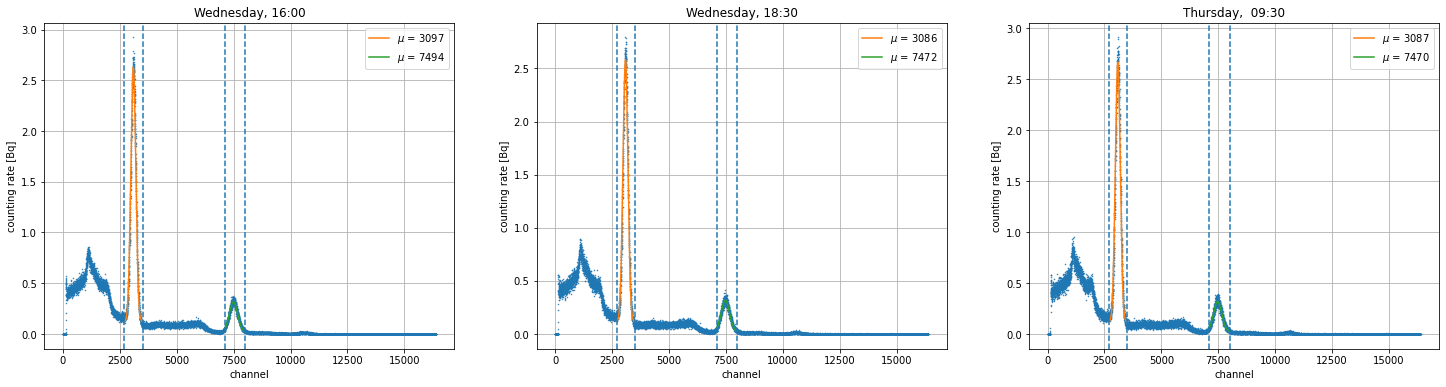

In [26]:
# Analysis of the sodium spectrum

channels = np.arange(1, len(N_Na1)+1, 1)

a = [[2700, 3500], [2700, 3500], [2700, 3500]]
b = [[7100, 8000], [7100, 8000], [7100, 8000]]

fig, ax = plt.subplots(1,3, figsize=(25,6))
coeffs_Na = np.zeros((6, 4))
cov_Na = np.zeros((6, 4, 4))

error_step = 100

for i in range(3):
    coeffs_Na[2*i], cov_Na[2*i] = sc.curve_fit(gauss, channels[a[i][0]:a[i][1]], n_Na[i][a[i][0]:a[i][1]],
                                   sigma = u_Na[i][a[i][0]:a[i][1]], absolute_sigma=True,
                                   p0=(2, 0.5*(a[i][0]+a[i][1]), 120, 150))
    coeffs_Na[2*i+1], cov_Na[2*i+1] = sc.curve_fit(gauss, channels[b[i][0]:b[i][1]], n_Na[i][b[i][0]:b[i][1]],
                                   sigma = u_Na[i][b[i][0]:b[i][1]], absolute_sigma=True,
                                   p0=(2, 0.5*(b[i][0]+b[i][1]), 120, 150))


    print(coeffs_Na[2*i], np.sqrt(np.diagonal(cov_Na[2*i])))
    print(coeffs_Na[2*i+1], np.sqrt(np.diagonal(cov_Na[2*i+1])))
    # ax[i].errorbar(channels[0:-1:error_step], n_Na1[0:-1:error_step],
    #             yerr=u_Na1[0:-1:error_step],
    #             fmt='none', c='black', zorder=10)

    ax[i].plot(channels, n_Na[i], lw=0, marker = '.', ms = 1)
    ax[i].plot(channels[a[i][0]:a[i][1]], gauss(channels[a[i][0]:a[i][1]], *coeffs_Na[2*i]),
               label = r'$\mu$ = {:.0f}'.format(coeffs_Na[2*i][1]))
    ax[i].plot(channels[b[i][0]:b[i][1]], gauss(channels[b[i][0]:b[i][1]], *coeffs_Na[2*i+1]),
              label = r'$\mu$ = {:.0f}'.format(coeffs_Na[2*i+1][1]))
    ax[i].axvline(channels[a[i][0]], ls = '--')
    ax[i].axvline(channels[a[i][1]], ls = '--')
    ax[i].axvline(channels[b[i][0]], ls = '--')
    ax[i].axvline(channels[b[i][1]], ls = '--')

    ax[i].set_xlabel('channel')
    ax[i].set_ylabel('counting rate [Bq]')

    ax[i].legend()
    ax[i].grid()

ax[0].set_title('Wednesday, 16:00')
ax[1].set_title('Wednesday, 18:30')
ax[2].set_title('Thursday,  09:30')
plt.show()

[1.11268356e-01 6.87999714e+03 1.61656393e+02 2.79614340e-02] [8.47749840e-04 1.06236465e+00 1.74791665e+00 6.39286771e-04]
[9.74061442e-02 7.79913389e+03 1.91444519e+02 7.60198080e-03] [7.24541906e-04 1.08442902e+00 2.05057790e+00 6.37283651e-04]
[1.18388364e-01 6.86458334e+03 1.62822412e+02 2.69230526e-02] [8.87714854e-04 1.04318255e+00 1.75100684e+00 6.77354387e-04]
[1.01286873e-01 7.78265575e+03 1.90585395e+02 8.24800690e-03] [7.35141186e-04 1.10953586e+00 1.92217209e+00 5.94537444e-04]
[1.15717551e-01 6.86005715e+03 1.68379421e+02 2.54098972e-02] [8.12854347e-04 9.75008721e-01 1.74124039e+00 6.71491639e-04]
[1.01080931e-01 7.78032371e+03 1.91800892e+02 7.05188677e-03] [6.59156625e-04 1.00996783e+00 1.73624456e+00 5.27581488e-04]


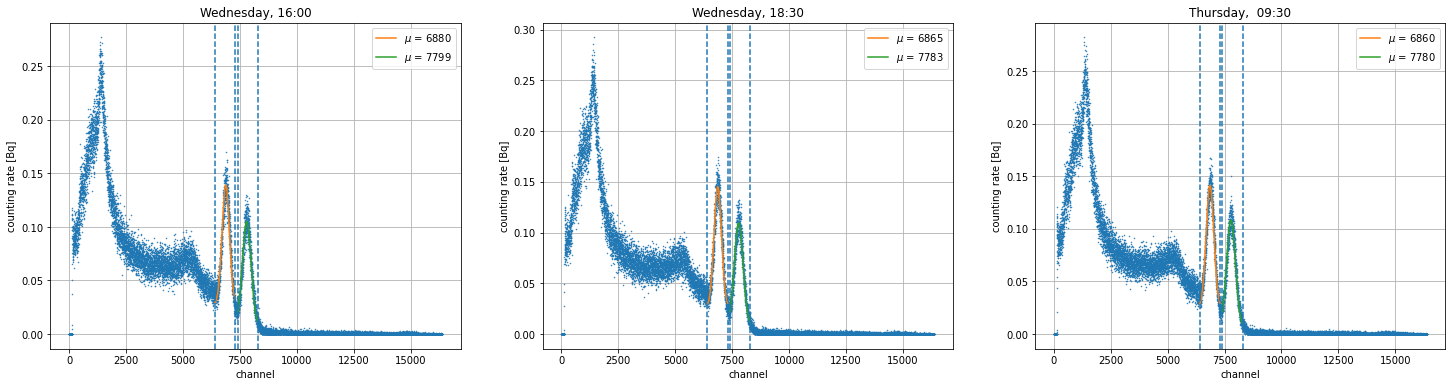

In [34]:
# Analysis of the cobalt spectrum

channels = np.arange(1, len(N_Co1)+1, 1)

a = [[6400, 7300], [6400, 7300], [6400, 7300]]
b = [[7400, 8300], [7400, 8300], [7400, 8300]]

fig, ax = plt.subplots(1,3, figsize=(25,6))
coeffs_Co = np.zeros((6, 4))
cov_Co = np.zeros((6, 4, 4))

error_step = 100

for i in range(3):
    coeffs_Co[2*i], cov_Co[2*i] = sc.curve_fit(gauss, channels[a[i][0]:a[i][1]], n_Co[i][a[i][0]:a[i][1]],
                                   sigma = u_Co[i][a[i][0]:a[i][1]], absolute_sigma=True,
                                   p0=(2, 0.5*(a[i][0]+a[i][1]), 120, 150))
    coeffs_Co[2*i+1], cov_Co[2*i+1] = sc.curve_fit(gauss, channels[b[i][0]:b[i][1]], n_Co[i][b[i][0]:b[i][1]],
                                   sigma = u_Co[i][b[i][0]:b[i][1]], absolute_sigma=True,
                                   p0=(2, 0.5*(b[i][0]+b[i][1]), 120, 150))


    print(coeffs_Co[2*i], np.sqrt(np.diagonal(cov_Co[2*i])))
    print(coeffs_Co[2*i+1], np.sqrt(np.diagonal(cov_Co[2*i+1])))
    # ax[i].errorbar(channels[0:-1:error_step], n_Co1[0:-1:error_step],
    #             yerr=u_Co1[0:-1:error_step],
    #             fmt='none', c='black', zorder=10)

    ax[i].plot(channels, n_Co[i], lw=0, marker = '.', ms = 1)
    ax[i].plot(channels[a[i][0]:a[i][1]], gauss(channels[a[i][0]:a[i][1]], *coeffs_Co[2*i]),
               label = r'$\mu$ = {:.0f}'.format(coeffs_Co[2*i][1]))
    ax[i].plot(channels[b[i][0]:b[i][1]], gauss(channels[b[i][0]:b[i][1]], *coeffs_Co[2*i+1]),
              label = r'$\mu$ = {:.0f}'.format(coeffs_Co[2*i+1][1]))
    ax[i].axvline(channels[a[i][0]], ls = '--')
    ax[i].axvline(channels[a[i][1]], ls = '--')
    ax[i].axvline(channels[b[i][0]], ls = '--')
    ax[i].axvline(channels[b[i][1]], ls = '--')

    ax[i].set_xlabel('channel')
    ax[i].set_ylabel('counting rate [Bq]')

    ax[i].legend()
    ax[i].grid()

ax[0].set_title('Wednesday, 16:00')
ax[1].set_title('Wednesday, 18:30')
ax[2].set_title('Thursday,  09:30')
plt.show()

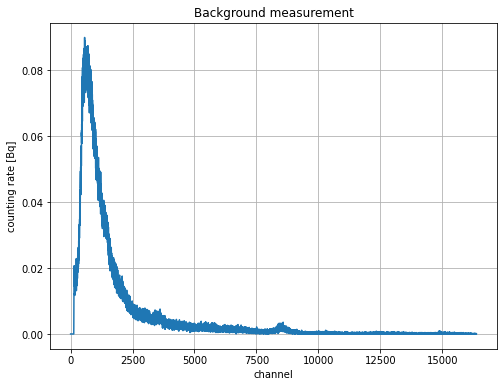

In [41]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(channels, n_under)
ax.grid()
ax.set_title('Background measurement')
ax.set_xlabel('channel')
ax.set_ylabel('counting rate [Bq]')
plt.show()

In [35]:
print(t_Na1, t_Na2, t_Na3)
print(t_Co1, t_Co2, t_Co3)

500 360 300
1064 1000 1200


In [46]:
energies = np.array([511, 1274.6, 1173.2, 1332.5])
ch_num = np.array([round(np.mean([coeffs_Na[2,1], coeffs_Na[4,1]])),
                   round(np.mean([coeffs_Na[3,1], coeffs_Na[5,1]])),
                   round(np.mean([coeffs_Co[2,1], coeffs_Co[4,1]])),
                   round(np.mean([coeffs_Co[3,1], coeffs_Co[5,1]]))])

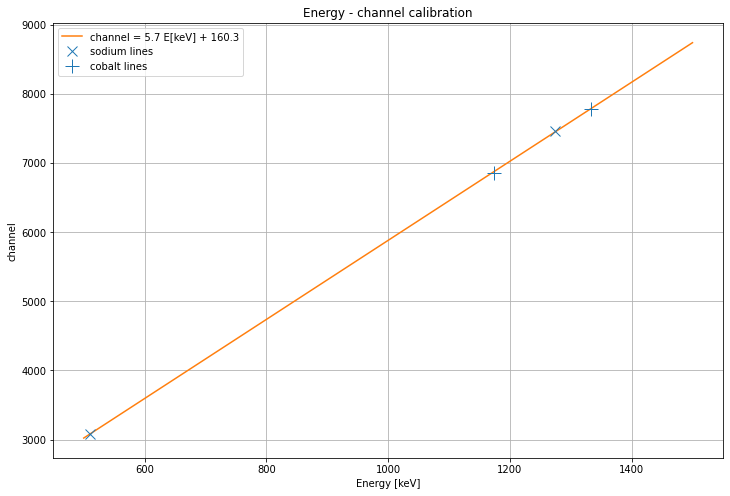

In [64]:
coeffs_lin, cov_lin = sc.curve_fit(linear_fct, energies, ch_num)

e_axis = np.linspace(500, 1500, 1001)

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(e_axis, linear_fct(e_axis, *coeffs_lin), c='C1', label= r'channel = {:.1f} E[keV] + {:.1f}'.format(*coeffs_lin))
ax.plot(energies[:2], ch_num[:2], marker = 'x', ms=10, lw = 0, label = 'sodium lines', c='C0')
ax.plot(energies[2:], ch_num[2:], marker = '+', ms=14, lw = 0, label = 'cobalt lines', c='C0')

ax.set_title('Energy - channel calibration')
ax.set_xlabel('Energy [keV]')
ax.set_ylabel('channel')
ax.legend()
ax.grid()
plt.show()

In [65]:
def energy(channel):
    m, c = coeffs_lin
    return (channel - c) / m


def u_energy(channel, u_channel=1):
    m, c = coeffs_lin
    u_m, u_c = np.sqrt(np.diagonal(cov_lin))
    return np.sqrt((u_channel/m)**2 + (u_c/m)**2 + (u_m*(channel-c)/m**2)**2)

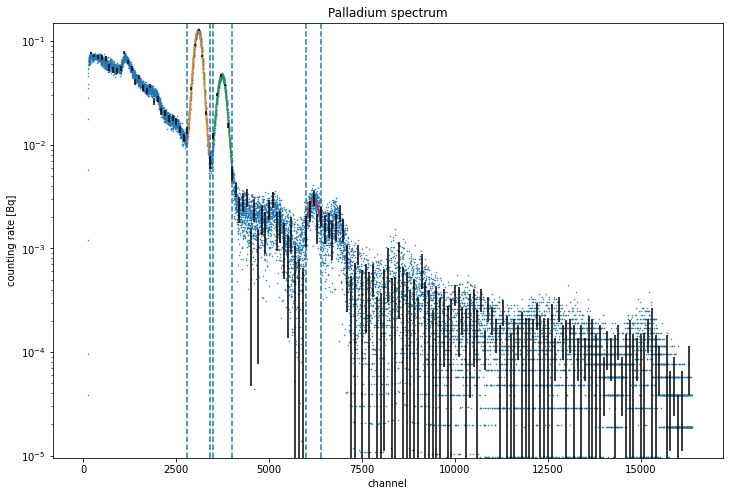

[ 1.20996108e-01  3.08388659e+03 -1.05801152e+02  6.83076710e-03] [1.69274627e-04 1.29288054e-01 2.06843723e-01 1.26273188e-04]
[4.35628751e-02 3.72391290e+03 1.18109739e+02 3.24302079e-03] [2.06398784e-04 2.92276153e-01 7.50789806e-01 2.23648867e-04]
[1.88910829e-03 6.19300497e+03 1.53712604e+02 1.08101340e-03] [8.71294222e-04 4.10658072e+00 5.14054458e+01 8.94969298e-04]
510.8517855683995
622.6879043501848
1054.1290357234318


In [82]:
# Analysis of the Palladium spectrum
channels = np.arange(1, len(N_Pd)+1, 1)
a1, b1 = 2800, 3400
a2, b2 = 3500, 4000
a3, b3 = 6000, 6400

coeffs_Pd1, cov_Pd1 = sc.curve_fit(gauss, channels[a1:b1], n_Pd[a1:b1],
                                   sigma=u_Pd[a1:b1], absolute_sigma=True,
                                   p0=(0.2, 0.5*(a1+b1), 200, 15))
coeffs_Pd2, cov_Pd2 = sc.curve_fit(gauss, channels[a2:b2], n_Pd[a2:b2],
                                   sigma=u_Pd[a2:b2], absolute_sigma=True,
                                   p0=(0.2, 0.5*(a2+b2), 200, 20))
coeffs_Pd3, cov_Pd3 = sc.curve_fit(gauss, channels[a3:b3], n_Pd[a3:b3],
                                   sigma=u_Pd[a3:b3], absolute_sigma=False,
                                   p0=(0.002, 0.5*(a3+b3), 200, 0.001))

fig, ax = plt.subplots(figsize=(12,8))

error_step = 100
ax.errorbar(channels[0:-1:error_step], n_Pd[0:-1:error_step],
            yerr=u_Pd[0:-1:error_step],
            fmt='none', c='black', zorder=10)

ax.plot(channels, n_Pd, lw=0, marker = '.', ms = 1)
ax.plot(channels[a1:b1], gauss(channels[a1:b1], *coeffs_Pd1))
ax.plot(channels[a2:b2], gauss(channels[a2:b2], *coeffs_Pd2))
ax.plot(channels[a3:b3], gauss(channels[a3:b3], *coeffs_Pd3))
ax.axvline(channels[a1], ls = '--')
ax.axvline(channels[b1], ls = '--')
ax.axvline(channels[a2], ls = '--')
ax.axvline(channels[b2], ls = '--')
ax.axvline(channels[a3], ls = '--')
ax.axvline(channels[b3], ls = '--')

ax.set_ylim((.5/t_Pd, 0.15))
ax.set_yscale('log')

ax.set_title('Palladium spectrum')
ax.set_xlabel('channel')
ax.set_ylabel('counting rate [Bq]')

plt.show()
print(coeffs_Pd1, np.sqrt(np.diagonal(cov_Pd1)))
print(coeffs_Pd2, np.sqrt(np.diagonal(cov_Pd2)))
print(coeffs_Pd3, np.sqrt(np.diagonal(cov_Pd3)))

print(energy(coeffs_Pd1[1]))
print(energy(coeffs_Pd2[1]))
print(energy(coeffs_Pd3[1]))

In [84]:
print(energy(coeffs_Pd1[1]), '+-', u_energy(coeffs_Pd1[1]), 'keV')
print(energy(coeffs_Pd2[1]), '+-', u_energy(coeffs_Pd2[1]), 'keV')
print(energy(coeffs_Pd3[1]), '+-', u_energy(coeffs_Pd3[1]), 'keV')

510.8517855683995 +- 4.891426506594109 keV
622.6879043501848 +- 5.091018734044272 keV
1054.1290357234318 +- 6.106446896956429 keV


In [13]:
### Source for Pd Term sceme:
# Abb.2.11 on p. 38
# http://iktp.tu-dresden.de/IKTP/pub/09/Marcel_Heine_-_Eine_Suche_nach_Doppelbeta-Zerfaellen_von_Cadmium-_%20Zink_und%20Tellur-_Isotopen_mit_Positronen-Emission.pdf

# both lines identified! Nice!!